Quadratic Assignment on Dirac
================================
#### Device: Dirac-1

The quadratic assignment problem was first introduced in 1957 by Koopmans and Beckmann to solve facility location problems which call for minimizing the cost proportional to the flow of goods between the facilities. This is a well studied problem.

QAP seeks to mimimize a cost function based on fixed quantities (weights) between pairs of one set, $P$, and distances between pairs of another set $L$ when each member of $L$ is assigned to one member of $P$.

## Importance

The problem itself is based on a hypothetical situation which is a possibly simplified but realistic planning problem. Although the context of the problem itself is quite different, it has the same double-one-hot constraint structure as [traveling salesperson](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/tsp-tutorial). This constraint structure comes from the fact that only one of each type of facility will be constructed, and each location can only accomodate one facility. As we will show in our example, the problem statement is more involved than with traveling salesperson, it is defined by distances between locations, flows between facilities, and the cost to construct at each location. The component of the objective function from the cost to move each flow a given distance leads to analogous terms to the traveling salesperson problem, terms which reference the location of two facilities, in the same way the distances which define traveling salesperson costs reference the times at which two cities are visited. The cost of bulding a facility at each location however provides terms which reference only the location of a single facility. This extra cost means that quadratic assignment has less symmetry then traveling salesperson. While the cost is the same in travelling salesperson regardless of the starting city (assuming the salesperson must end in that city), there is no analogous symmetry for quadratic assignment.

## Applications

As with many other problems, the quadratic assignment problem is motivated by a real task, deciding where to construct industrial facilities. While a real situation may involve additional constraints (for example regulations which do not allow a factory which works with dangerous chemicals to be located in certain parts of a city), this problem presents a simplified framework for understanding planning problems. In addition to the obvious planning application, which is how the problem is formulated, there are other less obvious applications as reviewed in [this paper](https://link.springer.com/article/10.1007/s12652-018-0917-x). These include for example hospital design, where the flow is a flow of patients rather than materials. Similarly the problem of placing components on a computer backboard to minimise the length of wires can be phrased as a QAP (with the wires being the flow in this case, and the components the facilities, representing an empty location as a facility with no cost and no flows). An even more exotic application of this problem is forest management, where facilities are representations of zoning of a location for a specific use (in this case there will be multiple facilities of the same type), and flows represent the desirability (or lack thereof) of having different types of areas in proximity to each other, for example having an area zoned as a wildlife preserve next to an area zoned for recreation (or others zoned as preserves) is desirable, while having recreation next to logging is not. 

Simple Example
-----------------

This first example is a synthetic problem with a five facilities and five locations. The first consideration is the planned flow between the facilities. The table below shows the quantity of material planned to be moved from one facility to the other. Facility 1 sends to facilities 2, 3 and 5. Facilites 2 and 3 send to facilities 4 and 5. Facility 4 doesn't send to any other faciilty and facility 5 sends one unit to facility 4.

| Source Facility / Destination Facility | Facility 1 | Facility 2 | Faclity 3 | Facility 4 | Facility 5 |
|---|---|---|---|---|---|
| **Facility 1**| | 5 | 8 |  | 1 |
| **Facility 2** | | | | 10 | 15 |
| **Facility 3** | | | | 13 | 18 |
| **Facility 4** | | | | | |
| **Facility 5** | | | | 1 | |

The second consideration is the distance between locations. The distances in this example are symmetric.

| Distances | Location 1 | Location 2 | Location 3 | Location 4 | Location 5 |
|---|---|---|---|---|---|
| **Location 1** | 0 | 8.54 | 6.4 | 10 | 8.94 |
| **Location 2** | 8.54 | 0 | 4.47 | 5.39 | 6.49 |
| **Location 3** | 6.4 | 4.47 | 0 | 3.61 | 3 |
| **Location 4** | 10 | 5.39 | 3.61 | 0 | 2 |
| **Location 5** | 8.94 | 6.49 | 3 | 2 | 0 |

The third consideration is the cost of building a facility at a location.

| Facility / Location | Location 1| Location 2 | Location 3 | Location 4 | Location 5 |
|---|---|---|---|---|---|
| **Facility 1**| 2 | 3 | 6 | 3 | 7 |
| **Facility 2** | 3 | 9 | 2 | 5 | 9 |
| **Facility 3** | 2 | 6 | 4 | 1 | 2 |
| **Facility 4** | 7 | 5 | 8 | 5 | 7 |
| **Facility 5** | 1 | 9 | 2 | 9 | 2 |

The outcomes in this example range from optimal to 166% of optimal. This implies a considerable benefit to performing the optimization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qci_client import QciClient
from helpers import plot_qap, assignment_from_solution, create_qap_objective, create_qap_constraints, find_index_of_nearest
from data import mip_obj_vals

Here is the data described in the tables above.

In [3]:

A = np.array([[0, 5, 8, 0, 1],
                [0, 0, 0, 10, 15],
                [0, 0, 0, 13, 18],
                [0, 0, 0, 0, 0.],
                [0, 0, 0, 1, 0.]])
B = np.array([[0, 8.54, 6.4, 10, 8.94],
                [8.54, 0, 4.47, 5.39, 6.49],
                [6.4, 4.47, 0, 3.61, 3.0],
                [10, 5.39, 3.61, 0, 2.0],
                [8.94, 6.49, 3.0, 2.0, 0.]])
C = np.array([[2, 3, 6, 3, 7],
                [3, 9, 2, 5, 9],
                [2, 6, 4, 1, 2],
                [7, 5, 8, 5, 7],
                [1, 9, 2, 9, 2.]])
n = 5
num_variables = 25

This code creates the objective matrix from the three input matrices, then uploads the data to the API.

In [4]:
token = "your_token"
api_url = "https://api.qci-prod.com"
qciclient = QciClient(api_token=token, url=api_url)

Here we start a client for the API and upload the objective matrix.

The constraint matrix is built using only the number of facilities/locations. It is the same across all problems of the same size, independent of the other input data.

This code builds the constraint data and uploads two files, one for the left hand side and another for the right.

In [5]:
constraint_file = create_qap_constraints(n)
constraint_file_id = qciclient.upload_file(file=constraint_file)["file_id"]

In [6]:
objective_file = create_qap_objective(A, B, C, n, num_variables)
obj_file_id = qciclient.upload_file(file=objective_file)["file_id"]

This is where we make the job request. The request is synchronous, but could be made asynchronously and results retrieved at a later time.

In [7]:

alpha = 105.625
job_params = {"device_type": "dirac-1", "alpha": alpha, "num_samples": 5}
body = qciclient.build_job_body(job_type="sample-constraint", job_params=job_params,
    constraints_file_id=constraint_file_id, objective_file_id=obj_file_id,
    job_name=f"QAP Demo",
    job_tags=[])
# submit the job request to be processed asynchronously
response = qciclient.process_job(job_body=body)

2024-05-01 15:32:04 - Dirac allocation balance = 0 s (unmetered)
2024-05-01 15:32:05 - Job submitted: job_id='66325265e15a79bd9d02c65c'
2024-05-01 15:32:05 - QUEUED
2024-05-01 15:32:08 - RUNNING
2024-05-01 15:34:17 - COMPLETED
2024-05-01 15:34:20 - Dirac allocation balance = 0 s (unmetered)


The response includes results samples and energies.

In [8]:
response['results']

{'counts': [4, 1],
 'energies': [-725.6101734638214, -724.4597828388214],
 'feasibilities': [True, False],
 'objective_values': [330.6400022506714, 120.53999900817871],
 'solutions': [[1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1],
  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]]}

In [9]:
results = response["results"]
sample = np.array(results["solutions"])

We convert the bit vector of length 25 into an array of assignments of length 5 and plot the assignments in a bi-partite graph.

In [10]:
assignment = assignment_from_solution(sample[0], n)
assignment

[0, 3, 2, 1, 4]

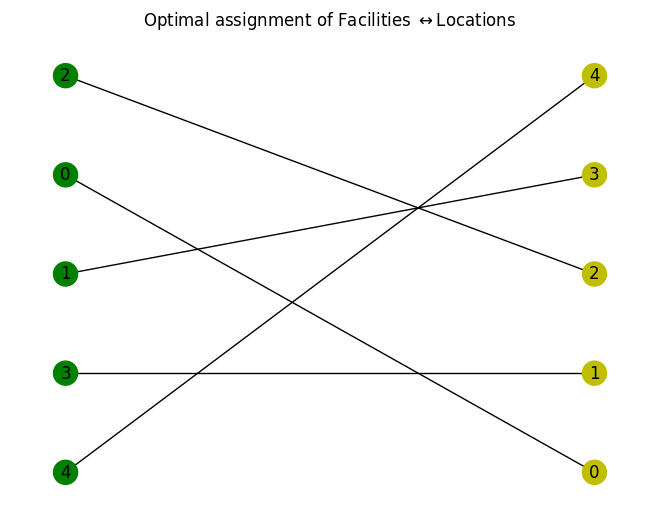

In [11]:
plot_qap(assignment)

These values were obtained by enumerating all feasible solutions and evaluating the objective function. 

Results
========

In this plot, the objective values of all feasible solutions are shown with the objective value of the solution found by **Dirac 1**. Notice the result is the lowest possible objective value.

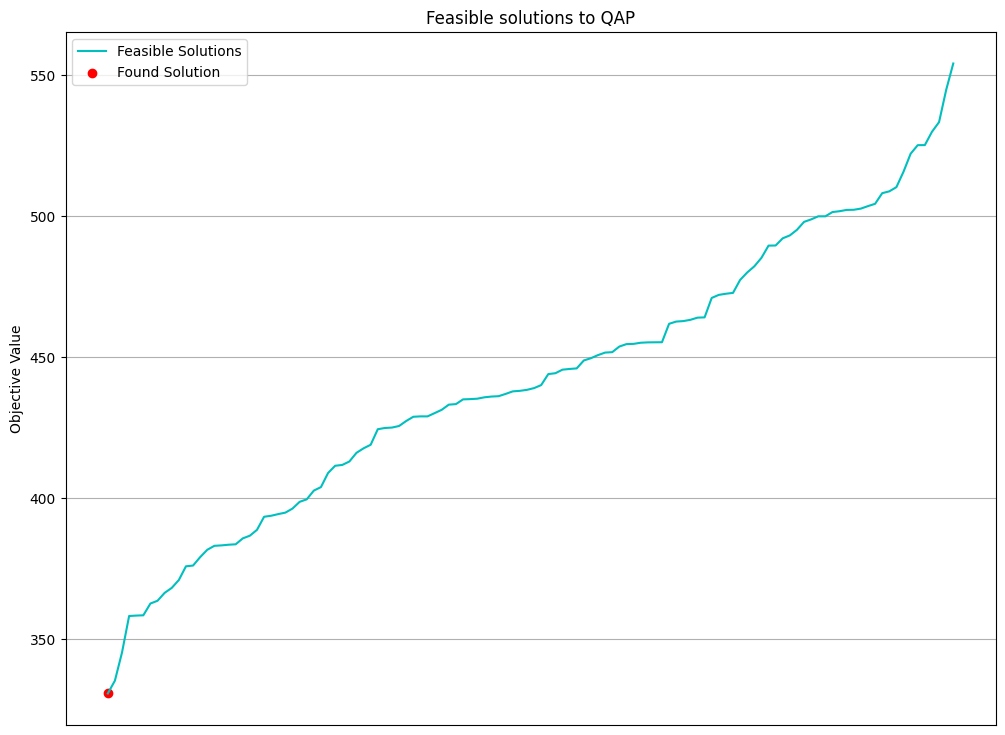

In [33]:
plt.figure(figsize=(12, 9))
ser1 = plt.plot(mip_obj_vals, "c-", label="Feasible Solutions")
plt.title("Feasible solutions to QAP")
ax = plt.gca()
plt.xlabel("Feasible Solution")
ax.get_xaxis().set_visible(False)
plt.ylabel("Objective Value")
# ser2 = plt.plot([0, len(mip_obj_vals)-1], [results["energies"][0], results["energies"][0]], label="Found Solution")
obj_val = results["objective_values"][0]
idx = find_index_of_nearest(mip_obj_vals, obj_val)
ser2 = plt.scatter([idx], [obj_val], c="r", marker="o", label="Found Solution")
plt.legend()
plt.grid()

## Conclusion

In this tutorial we have learned about the quadratic assignment problem. While distinct quadratic assignment shares the same constraint structure as [traveling salesperson](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/tsp-tutorial). While less well known than traveling salesperson, quadratic assignment is a rich problem which has many practical applications. A logical next step could be to explore other, constrained problems which are device can solve through the [quadratic linearly constrained binary optimisation](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/quadratic-linearly-constrained-binary-optimization) page. Of course another option is to start using our device to solve some of your own optimisation problems.